# The Oh My Information - Lab

In this assignment we take on, or really return to _taxic exploration_. We revisit the sniff world (aka _ScentGrid_), with a new twist. What happens when sense information is not just noisy, but suddenly missing altogether. A concrete case of this is turbulent flows. 

We'll be working with a crude approximation of such flows. Our environment this tims just deletes scent information from the grid, with a probability $(1- p_{scent})$. The noisy background is of course unaffected by this deletion.

The presence of this uncertainty makes decisions--of the kind common to decision theory--a necessity. So, we'll be using accumulator models, again. The decisions to be made are: 

- Q1: Is their a scent at all?
- Q2: Is the gradient increasing or decreasing? 

Our target metrics are number of deaths, total reward, and best reward. Any experimental trial which does not lead to finding at least a single target (aka reward) means the exploring agent dies. It's a harsh noisy world we live in, after all. 

## E Coli, again?
_Background_: Recall our basic model of E. Coli exploration is as simple as can be. 

- When the gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_. 
- When the gradient is negative, the turning probability is set to _p neg_. (See code below, for an example). 
- If the agent "decides" to turn, the direction it takes is uniform random.
- The length of travel before the next turn decision is sampled from an exponential distribution just like the _DiffusionDiscrete_

## Our agents, this time
We will study three agents. One who does _chemotaxis_. One who does a kind of _infotaxis_. One that does random search (aka Diffusion). For fun, let's call this one a _randotaxis_ agent. (No one really calls them this.) This last rando-agent is really a control. A reference point.

In a sense the _chemotaxis_ agent only tries to answer question Q2 (above). While _infotaxis_ only tries to answer Q1. They are extreme strategies, in other words. The bigger question we will ask, in a very limited setting, is which extreme methods is better _generally_? 

We will not address the question of combining them, into a less extreme and perhaps more reliable alternative...

## Costly cognition
Both _chemo-_ and _infotaxis_ agents will use a DDM-style accumulator to try and make better decisions about the direction of the gradient. These decisions are of course statistical in nature. (We won't be tuning the accumulator parameters in this lab. Assume the parameters I give you, for the DDM, are "good enough".)

For the _randotaxis_ agent number of steps means the number of steps or actions the agent takes. 

As in the _Air Quotes Lab_ we will assume that the steps are in a sense conserved. For the other two (accumulator) agents a step can mean two things. For accumulator agents a step can be spent sampling/weighing noisy scent evidence in the same location, or it can be spent moving to a new location.

## What's scent look like (a definition of _chemotaxis_)?
Our _chemotaxis_ agent (_AccumulatorGradientGrid_) tries to directly estimate the gradient $\nabla$ in scent by comparing the level of scent at the last grid position it occupied to the current scent level ($o$). By last grid position here we mean the last grid position when it moved last. 

$$\nabla \approx o_t - o_{t-1}$$

Because an accumulator is present, our chemo- sequentially tries to estimate this gradient by sampling the new current location, until the threshold is met.

 Chemo-accumulators have what we can think of as two cognitive or behavioral steps:

1. Use an accumulator to (stabely) estimate the chemo gradient
2. Use the gradient to make turning decisions

## More information (a definition of _infotaxis_)?
Compared to chemo- definition the definition of infotaxis is a little more involved. It has what we can think of as five cognitive or behavioral steps:

1. Use an accumulator to (stabely) estimate if there is a scent or not. AKA hits and misses.
2. Build a probability model of hits/misses (at every point)
3. Measure information gained when probability model changes 
4. Measure the gradient of information gains
5. Use the gradient to make turning decisions

_Note_: Even though the info-accumulator is more complex, it can take advantage of missing scent information to drive its behavior. It can also use positive scent hits, of course, too.

## Our TED talk moment
The big question for the week is this - is it ever better to follow the scent gradient instead of following its information?

## Install and import needed modules

In [ ]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

In [13]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

In [14]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 1 -  Intelligent costs, for fun
### Random search versus Cognition, when information is often missing and noisy

To build some intuition, let's plot the "scent" emmited by a single target. That same scent corrupts by 1/2 a standard deviation of noise. That same signal, with all but 10 percent of it deleted. That same signal corrupts by noise _and_ all but 10 percent of it deleted.

### Full scent

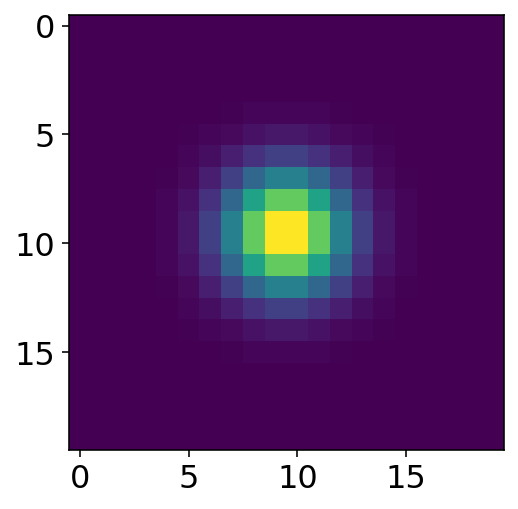

In [15]:
amplitude = 1

coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=amplitude, sigma=2)
plt.imshow(scent, interpolation=None)

### Noisy scent
A single examaple.

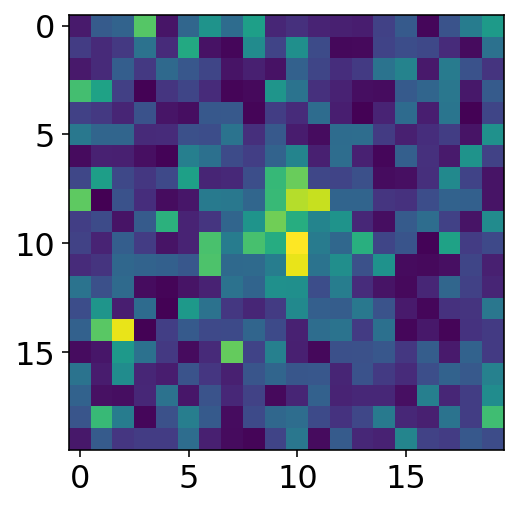

In [43]:
amplitude = 1
noise_sigma = 0.5

coord, scent = create_grid_scent_patches(target_boundary, p=1.0, amplitude=amplitude, sigma=2)
scent = add_noise(scent, noise_sigma)

plt.imshow(scent, interpolation=None)

Average 100 noisy scents to prove the orginal pure scent is still in there

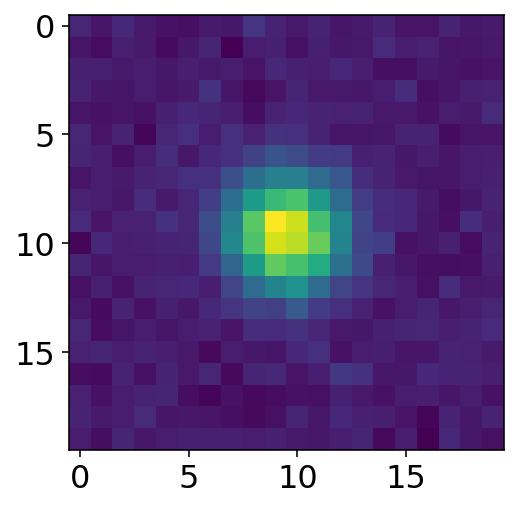

In [57]:
amplitude = 1
noise_sigma = 0.5
num_samples = 100

scents = []
for _ in range(num_samples):
    coord, scent = create_grid_scent_patches(target_boundary, p=1.0, amplitude=1, sigma=2)
    scent = add_noise(scent, noise_sigma)
    scents.append(deepcopy(scent))

scent = np.sum(scents, axis=0)

plt.imshow(scent, interpolation=None)

### Missing scent
A single example

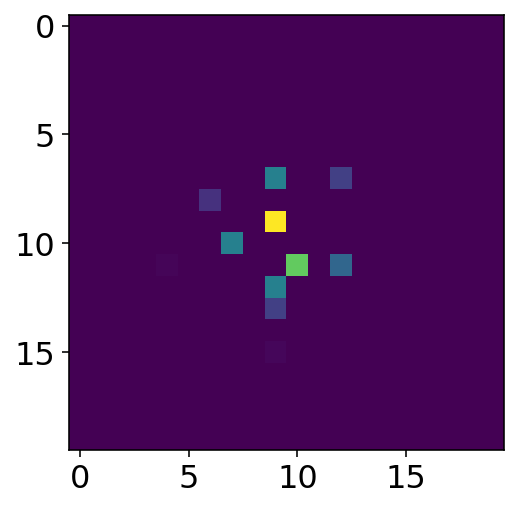

In [37]:
amplitude = 1000
p_scent = 0.1

coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=amplitude, sigma=2)

plt.imshow(scent, interpolation=None)

Average 100 of partially misssing scents to prove the orginal pure scent is still in there

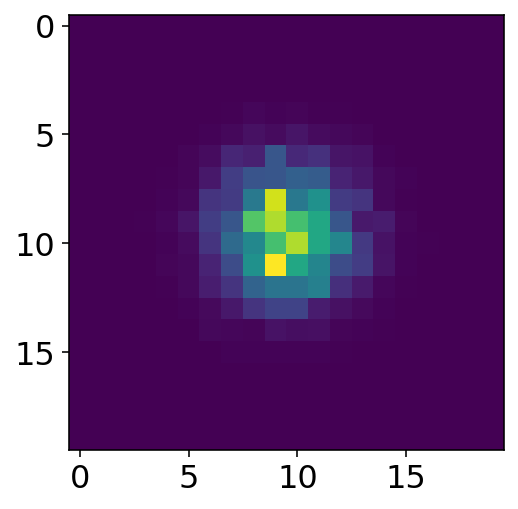

In [56]:
amplitude = 1
p_scent = 0.1
num_samples = 100

scents = []
for _ in range(num_samples):
    coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=1, sigma=2)
    scents.append(deepcopy(scent))

scent = np.sum(scents, axis=0)

plt.imshow(scent, interpolation=None)

### Noisy and missing scent
A single examaple

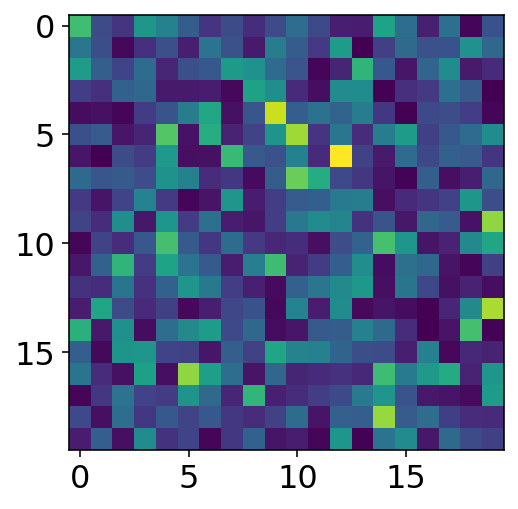

In [41]:
amplitude = 1
noise_sigma = 0.5
p_scent = 0.1
;
coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=amplitude, sigma=2)
scent = add_noise(scent, noise_sigma)

plt.imshow(scent, interpolation=None)

Average 100 of partially misssing _and_ noisy scents to prove the orginal pure scent is still in there

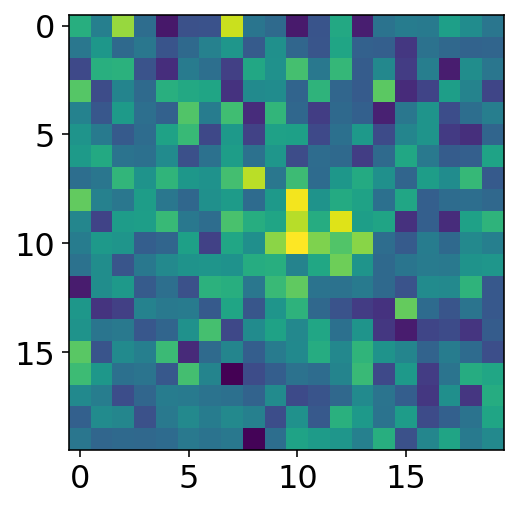

In [53]:
amplitude = 1
noise_sigma = 0.5
p_scent = 0.1
num_samples = 100

scents = []
for _ in range(num_samples):
    coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=1, sigma=2)
    scent = add_noise(scent, noise_sigma)
    scents.append(deepcopy(scent))
    
scent = np.sum(scents, axis=0)

plt.imshow(scent, interpolation=None)

#### Question 1.1
When scent is both noisy, and missing, the cost (in steps) of using cognition (aka accumulator-based evidential decision making) may not be worth it? 

If we define "worth it" to be both total reward, and num deaths, what do you think? Without a positive cognition step multiplier factor (as in the Air Cog Lab), will either chemo- or info-taxis agents outperform random search?

_Hint_: this is not a blind guess. If you change _num. samples_ in the plots above, to say betweeen 2-10, you will get a estimate of how accumulator may "see" the problem. 


In [59]:
# Write your answer here as a commment. Explain your reasoning. 

#### Question 1.2
In Q1.1 I said

>  If you change _num. samples_ in the plots above, to say betweeen 2-10, you will get a estimate of how accumulator may "see" the problem. 

Can you explain in your own words why this assertion was correct? (Or if you think it was not correct, explain why)

In [60]:
# Write your answer here as a commment. Explain your reasoning. 

Let's find out how helpful or not cognition is when scents are noisy and missing

In [86]:
# Noise and delete
p_scent = 0.1
noise_sigma = 0.5

# Shared 
num_experiments = 100
num_steps = 200
seed_value = 5838

# ! (leave alone)
detection_radius = 1
cog_mult = 1
max_steps = 1
min_length = 1
num_targets = 10
target_boundary = (10, 10)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

In [87]:
# Agents
diff = DiffusionGrid(min_length=min_length, scale=1)
diff.seed(seed_value)

chemo = AccumulatorGradientGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
chemo.seed(seed_value)

info = AccumulatorInfoGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
info.seed(seed_value)

# !
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

info: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


### Behavior
A single example 

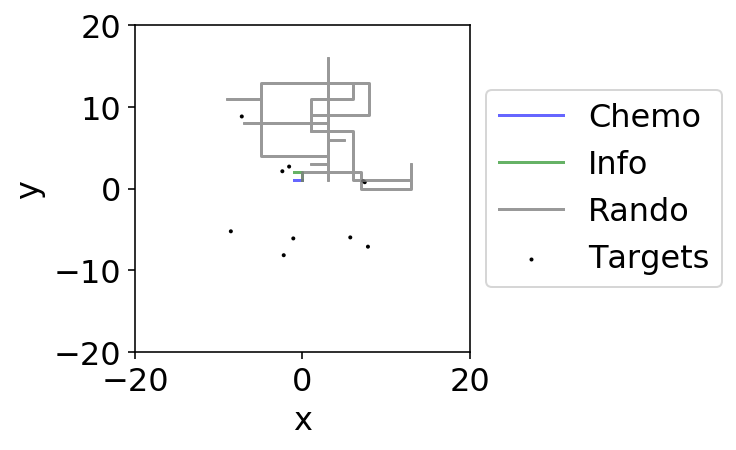

In [88]:
plot_boundary = (20, 20)

# -
num_experiment = 0
ax = None
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(info_exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="grey",
    alpha=0.8,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Total distance

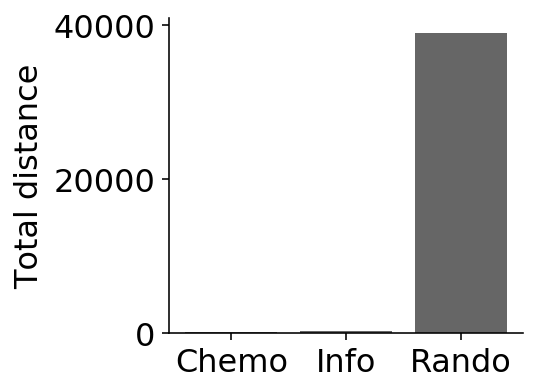

In [89]:
# Results
results = [chemo_exp, info_exp, rand_exp]
names = ["Chemo", "Info", "Rando"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    l = 0.0
    for r in res:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.tight_layout()
sns.despine()

### Deaths

num_death: 100%|██████████| 100/100 [00:00<00:00, 20324.19it/s]


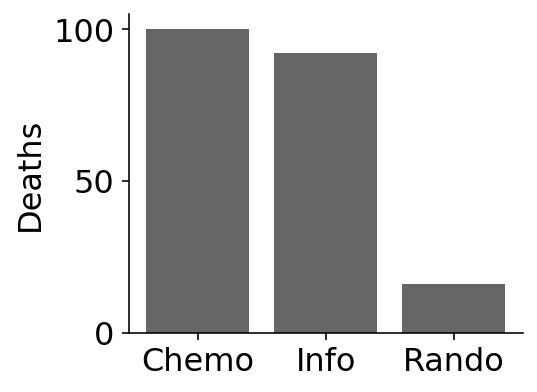

In [90]:
# Results
results = [chemo_exp, info_exp, rand_exp]
names = ["Chemo", "Info", "Rando"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

### Total reward

total_reward: 100%|██████████| 100/100 [00:00<00:00, 20467.01it/s]


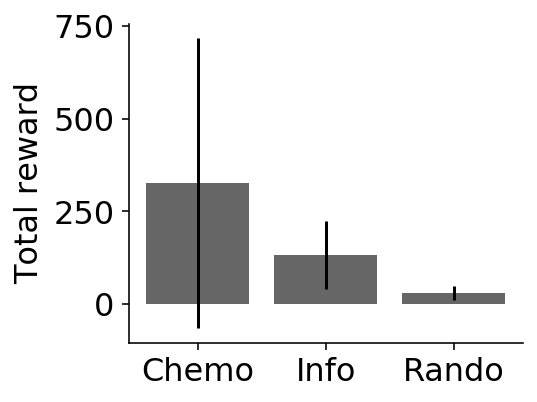

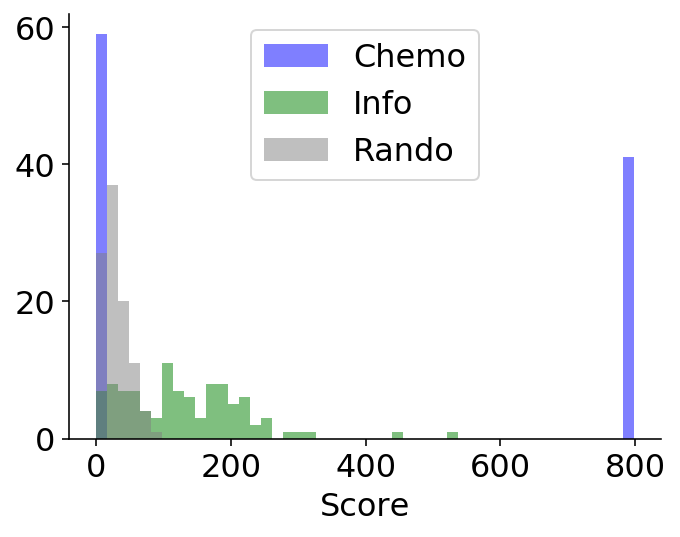

In [108]:
# Results
results = [chemo_exp, info_exp, rand_exp]
names = ["Chemo", "Info", "Rando"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

#### Question 1.3
So, is cognition worth it in the example following Q1.2? Were you right?

Base your answer on the number of deaths contrasted to the total reward. Both of which are plotted above.

In [ ]:
# Write your answer here as a commment. Explain yourself.

#### Question 1.4
Why were the number of deaths so much higher for chemo- and info-taxis?

In [99]:
# Write your answer here as a commment. Explain yourself.

## Section 2 -  Missing and noisy scents

Let's add a cog. mult. of 4. This will be enough to make evidenctial decsions "worth it". 

Having set our multiplier, let's compare chemo- and info-taxis in a setting which should favor chemo. We are not interested then _if_ chemo does better, but by how much.

In [101]:
cog_mult = 4

In [ ]:
# ADD HERE

## Section 3 -  Strong, but a little noisy

Let's add a cog. mult. of 4. This will be enough to make evidenctial decsions "worth it". 

In [94]:
cog_mult = 4

### Question 3.1
When there are "many" targets (50), and when noise is "low" 0.1), how much better will chemo-taxis be than info? 

Express this as a factor. For example, "I think chemo will be 2 x better" or "I think chemo will be 1 x better" (aka the same).

Before you jump to speculating, you might want to reread the opening section of this Lab, where I explain how info gradients are estimate and what goes into those estimates?

In [93]:
# Write your answer here as a commment. Explain yourself (as best you can).

Let's find out!

In [95]:
# Noise and delete
p_scent = 1.0
noise_sigma = 0.1

# Shared 
num_experiments = 100
num_steps = 200
seed_value = 5838

# ! (leave alone)
detection_radius = 1
max_steps = 1
min_length = 1

num_targets = 50
target_boundary = (10, 10)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=p_scent, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

In [96]:
# Agents
diff = DiffusionGrid(min_length=min_length, scale=1)
diff.seed(seed_value)

chemo = AccumulatorGradientGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
chemo.seed(seed_value)

info = AccumulatorInfoGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
info.seed(seed_value)

# !
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

info: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


### Deaths

num_death: 100%|██████████| 100/100 [00:00<00:00, 15600.91it/s]


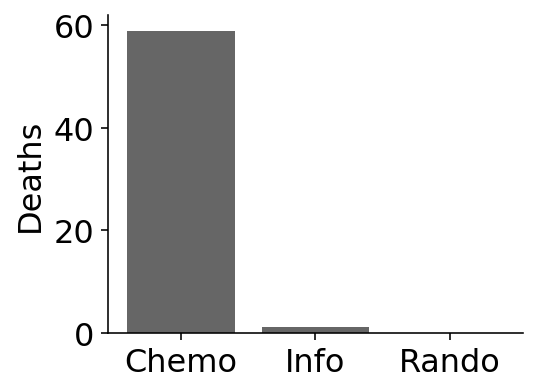

In [102]:
# Results
results = [chemo_exp, info_exp, rand_exp]
names = ["Chemo", "Info", "Rando"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

### Total reward

total_reward: 100%|██████████| 100/100 [00:00<00:00, 6535.02it/s]


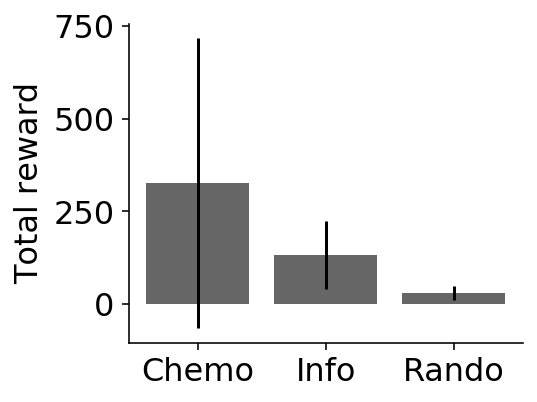

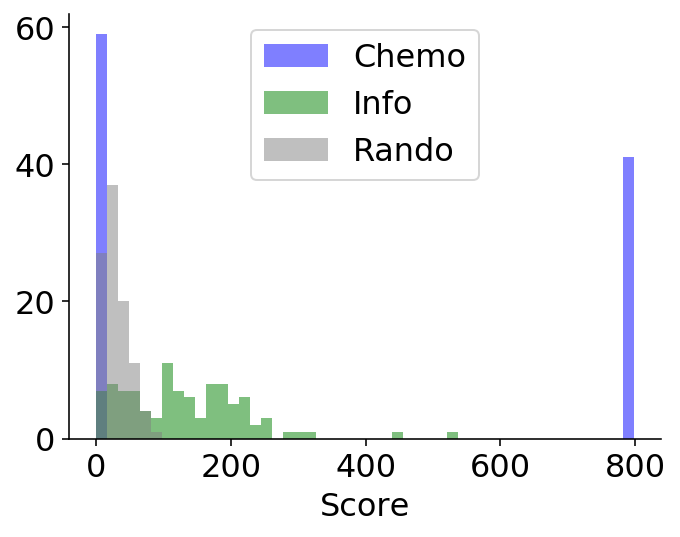

In [107]:
# Results
results = [chemo_exp, info_exp, rand_exp]
names = ["Chemo", "Info", "Rando"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

#### Question 3.2
Was you answer to 3.1 correct? If it was not, explain what you think you got wrong. 

In [ ]:
# Write your answer here as a commment. Explain your old intuition, and if it has changed, you new one.

#### Question 3.3
Is it better to follow your nose (aka do chemo-taxis) or it is better to do info-taxis--if you had to choosee only one of them? 

Consider the results for Sections 2 and 3 as a whole. Assume (wrongly) these simple tasks and models are a good standin for the natural world as a whole.

In [109]:
# Write your answer here as a commment. Explain yourself.

#### Question 3.4
Of course there is no reason an intelligent animal would need to use only info-taxis or only chemo-taxis. Describe below a algorthim, or scheme, to unify these two approaches. 

_Be as detailed as you can be._

In [ ]:
# Write your answer here as a commment. Explain yourself.

#### Question 3.5

Two recurring themes in these labs have been:
- Many "intelligent" algorithms come with cost
- Inductive bias will always fail; there is always a counterexample.

On the basis of these themes, create a counterexample for the scheme you created in Q1.4. Under what conditions will your new idea probably fail to do better than either approach working independently? 

In [ ]:
# Write your answer here as a commment. Explain yourself.